<a href="https://colab.research.google.com/github/OseiasBeu/fight_project/blob/main/EDA_UFC_Project_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')


ufc_raw = pd.read_csv("https://raw.githubusercontent.com/OseiasBeu/fight_project/main/datasets/data.csv")
ufc_final = pd.read_csv("https://raw.githubusercontent.com/OseiasBeu/fight_project/main/datasets/UFC_processado.csv")

In [33]:
#Choropleth Map:

# extract country from location
ufc_raw["country"] = ufc_raw["location"].apply(lambda loc: loc.split(',')[-1][1:])

# convert country to alpha3 code
country_codes = []
for country in ufc_raw["country"]: 
    if (country == 'Russia' or country ==  'russia'):
        country = "Russian Federation"
    if (country == 'South Korea'):
        country = "KR"        
    country_codes.append(pycountry.countries.lookup(country).alpha_3)

# value counts dataframe
ufc_worldwide = pd.DataFrame(np.array(country_codes))
ufc_worldwide = ufc_worldwide.iloc[:,0].value_counts().reset_index().rename(columns={"index":"country_code",0:"matches"})
ufc_worldwide.head(5)

,country_code,matches
0,USA,3392
1,BRA,405
2,CAN,342
3,GBR,255
4,AUS,162


# Distribuição de lutas pelo globo:

In [34]:
fig1 = go.Figure(
  data = go.Choropleth(
    locations = ufc_worldwide['country_code'], #alpha3 codes
    z = ufc_worldwide['matches'],
    text = "Eventos",
    colorscale = 'Blues',
    autocolorscale = False,
    marker_line_color = 'lightgrey',
    marker_line_width = 0.5,
    colorbar_title = 'Nº de eventos'
  )
)

fig1.update_layout(
  title = {
    'text': "1993 - 2019 UFC PELO MUNDO TODO!",
    'x': 0.5,
    'y': 0.87,
  },
  geo = dict(
    showframe = False,
    showcoastlines = True,
    projection_type = 'equirectangular',
    showland = False,
    showlakes = True,

  )

)

fig1.show()


# Percentual de lutas por classe de peso:

In [35]:
weight_class_df = pd.DataFrame(ufc_raw["weight_class"].value_counts()).reset_index().rename({"index":"weight__class", "weight_class":"counts"}, axis=1)
fig2 = go.Figure(data=[go.Pie(labels=weight_class_df["weight__class"], values=weight_class_df["counts"], hole=.5, title="Weight Type")])
fig2.update_layout(
    title="Weight Class Donut Chart",
    font=dict(
        family="Arial",
        size=14,
        color="#7f7f7f"
    )
)
fig2.show()

# Quantidade de lutas por ano:

In [36]:
ufc_raw["Year"] = ufc_raw["date"].apply(lambda x: x.split("-")[0])
year_count_df = pd.DataFrame(ufc_raw["Year"].value_counts()).reset_index().rename({"index": "year", "Year": "counts"}, axis = 1)

bar_colors = ["#3caef2", ] * 27
bar_colors[0] = '#07466c' # change colour of specific bars

fig3 = go.Figure(data = [go.Bar(
        x = year_count_df["year"],
        y = year_count_df["counts"],
        marker_color = bar_colors # marker color can be a single color value or an iterable
        )],
    layout = go.Layout(
        xaxis = dict(showgrid = True,
                     tickmode = 'linear',
                     showticklabels = True,
                     tickangle = -70,
                     #nticks = 2
                    ),
        yaxis = dict(showgrid = True),
        title="UFC Matches over Years"
    )
)

fig3.show()

# Distribuição de medidas dos atletas:

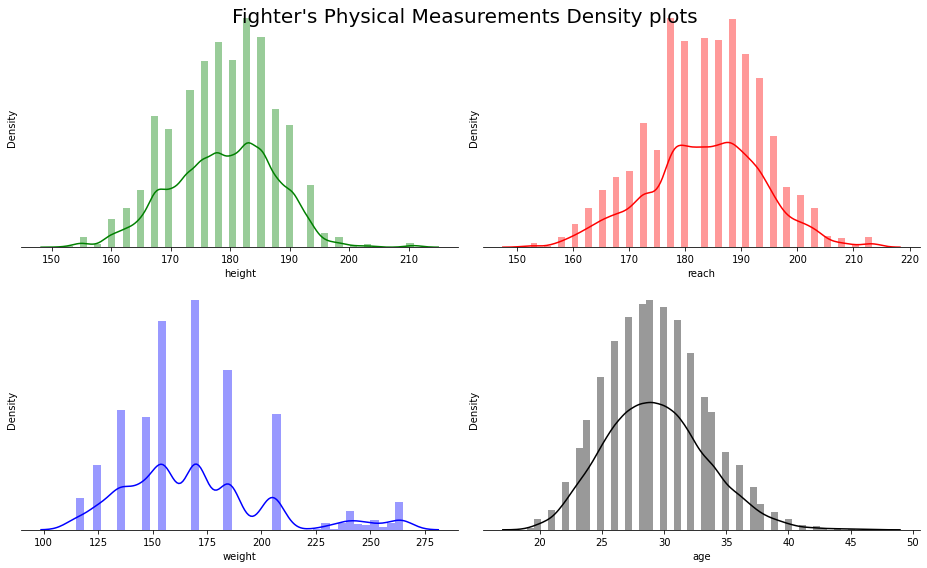

In [37]:
# combine measures of both blue and red fighter
height = pd.concat([ufc_raw["B_Height_cms"],ufc_raw["R_Height_cms"]],axis=0)
reach = pd.concat([ufc_raw["B_Reach_cms"],ufc_raw["R_Reach_cms"]],axis=0)
weight = pd.concat([ufc_raw["B_Weight_lbs"],ufc_raw["R_Weight_lbs"]],axis=0)
age = pd.concat([ufc_raw["B_age"],ufc_raw["R_age"]],axis=0)
fighter_measures = pd.DataFrame({"height":height, "reach":reach, "weight":weight, "age":age}).reset_index(drop=True).dropna()

# subplots:
fig4, axes = plt.subplots(2, 2, figsize=(13, 8), sharex=False) # Grid
fig4.suptitle("Fighter's Physical Measurements Density plots",fontsize=20) # Main title
sns.despine(left=True,right=True) # remove axis border

# density plots
#plt.title("Distribution of Height")
sns.distplot(fighter_measures["height"],color="green",
#             bins=10,
#             kde=True,
#             label='train',
              ax=axes[0, 0] # position in grid
            )
#plt.legend()
sns.distplot(fighter_measures["reach"],color="red",ax=axes[0, 1])
sns.distplot(fighter_measures["weight"],color="blue",ax=axes[1, 0])
sns.distplot(fighter_measures["age"],color="black",ax=axes[1, 1])

plt.setp(axes, yticks=[]) # y-ticks range disabled
plt.tight_layout() #auto-adjusts subplots to the figure area

# Distribuição de idade por atletas:

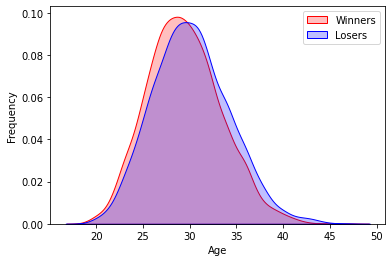

In [38]:
# Explore Age distibution 
winners_age_combinded = pd.concat([ufc_final["B_age"][(ufc_final["Winner"] == 1) ], # age of blue winners
                                   ufc_final["R_age"][(ufc_final["Winner"] == 0) ] # age of red winners
                                  ]).reset_index(drop=True)

losers_age_combinded = pd.concat([ufc_final["B_age"][(ufc_final["Winner"] == 0) ], # when winner was 0(red), what's the age of loser (b_age)
                                   ufc_final["R_age"][(ufc_final["Winner"] == 1) ] # same logic as above. age of red loser
                                  ]).reset_index(drop=True)
g = sns.kdeplot(winners_age_combinded, color="Red", shade = True)
g = sns.kdeplot(losers_age_combinded, color="Blue", shade = True, ax=g)


g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Winners","Losers"])

# Distribuição de vencedores por ano:

Text(0.5, 1.0, 'Winners Count by colour')

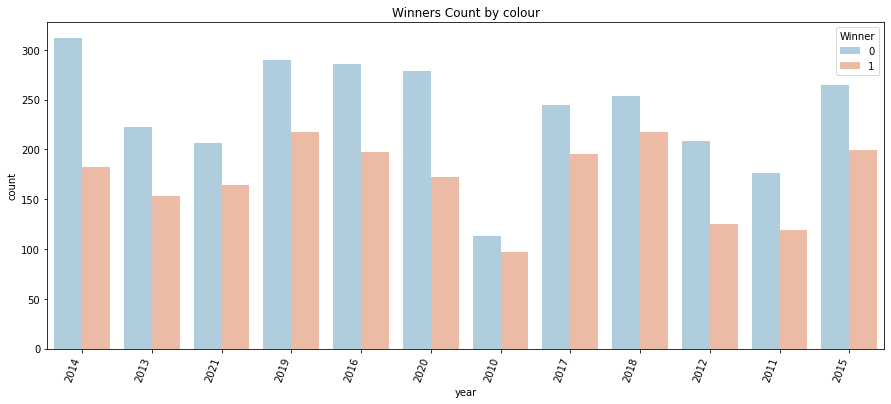

In [39]:
plt.figure(figsize=(15,6))
ufc_final["year"] = ufc_final["date"].str.split("-", expand=True)[0]
g = sns.countplot(
    data=ufc_final,
    x='year',
    palette='RdBu_r',
    hue="Winner"
)
g = g.set_xticklabels(g.get_xticklabels(), rotation=70, horizontalalignment='right')
plt.title("Winners Count by colour")